In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the train and test data

In [69]:
df_train = pd.read_csv("train_data.txt", sep=" ", names=["col1", "col2", "col3"])
df_test = pd.read_csv("test_data.txt", sep=" ", names=["col1", "col2", "col3"])

In [70]:
df_train.head()  # sanity check

,col1,col2,col3
0,-4.072524,-9.577501,0.0
1,-3.591656,-4.651351,2.0
2,-1.621404,-10.069722,0.0
3,-2.352587,-9.027460,0.0
4,1.690682,-0.521923,1.0


In [71]:
df_test.head()  # sanity check

,col1,col2,col3
0,-0.577060,-9.426309,0.0
1,-2.289926,-9.661375,0.0
2,-1.724228,-3.966204,2.0
3,-4.080085,-9.351840,0.0
4,2.143670,-1.731809,1.0


In [72]:
x_train = df_train[["col1", "col2"]].astype(np.float32).values
y_train = df_train["col3"].astype(np.float32).values
x_test = df_test[["col1", "col2"]].astype(np.float32).values
y_test = df_test["col3"].astype(np.float32).values

# Question 3 [60 points]: Linear Classifier Implementations 

a) [35 points: 15 points for each model, 5 points for evaluation] Using the provided dataset in the notebook, implement the perceptron and linear discriminant analysis (LDA) algorithms (use NumPy, Pandas) to classify the dataset. Then, report the accuracy of trained models. 

In [73]:
class Perceptron:
  
  def __init__ (self):
    self.w = None
    self.threshold = None
    
  def model(self, x):
    #Return 1 if (w*x) greater than or equal to threshold - Else return 0.
    result = np.where(self.w.T @ x >= self.threshold, 1, 0)

    return np.squeeze(result)
  
  def predict(self, X):
    #Predict values for the input X using the 'model' function above and store it in Y
    Y = self.model(X)
    return np.array(Y)
    
  def fit(self, X, Y, epochs = 1, lr = 1):

    self.w = np.zeros(X.shape[1]).reshape(-1, 1)
    self.threshold = 0

    accuracy = {}
    max_accuracy = 0
    wt_matrix = []

    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.predict(x.reshape(-1, 1))

        if y == 1 and y_pred == 0:
          #Update the w and threshold
          self.w = self.w + (lr * x.T.reshape(-1, 1)) * y
          # TODO: do I need to update the threshold here also?
      
        elif y == 0 and y_pred == 1:
          # modify this part
          self.w = self.w - (lr * x.T.reshape(-1, 1))
          
      wt_matrix.append(self.w)    
      accuracy[i] = accuracy_score(self.predict(X.T), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.threshold
    #checkpoint (Save the best weights and b value)
    self.w = chkptw.reshape(-1, 1)
    self.threshold = chkptb
        
    print(max_accuracy)
    #plot the accuracy values over epochs
    plt.plot(accuracy.values())
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.show()
    
    #return the weight matrix, that contains weights over all epochs
    return np.array(wt_matrix)


0.668


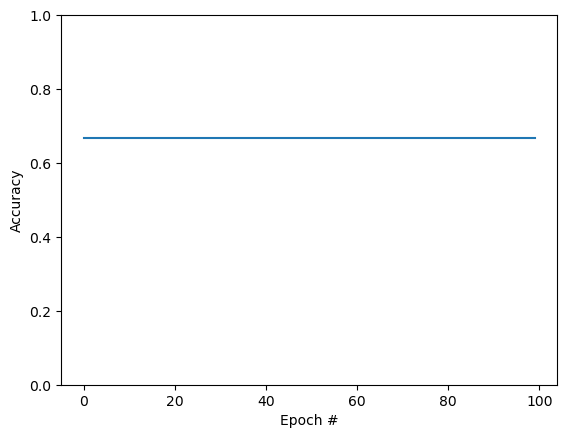

In [74]:
perceptron = Perceptron()
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
wt_matrix = perceptron.fit(x_train_scaled, y_train, 100, 0.001)

In [76]:
#Report the test accuracy for Perceptron. 
x_test_scaled = scaler.transform(x_test)
score = accuracy_score(perceptron.predict(x_test_scaled.T), y_test)
print(f"Test Accuracy: {round(score * 100, 2)}%.")

Test Accuracy: 66.67%.


In [61]:
import numpy as np

class LDA:
    '''
    Closed-form implementaion of linear discriminant analysis.

    Credit to the "Python Engineer" YouTube Lecture on LDA for explaining the math:
    https://www.youtube.com/watch?v=9IDXYHhAfGA
    '''
    def __init__(self, n_components):
        self.n_components = n_components  # after training + projection, this is how many dims we'll have
        self.linear_discriminants = None
        self.class_centroids = ...  # used for evaluation

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)
        scatter_within_cls = np.zeros((n_features, n_features))
        scatter_between_cls = np.zeros((n_features, n_features))
        for c in class_labels:
            samples_within_class = X[y == c]
            mean_class = np.mean(samples_within_class, axis=0)
            scatter_within_cls += (
                (samples_within_class - mean_class).T.dot((samples_within_class - mean_class))
            )
            n_c = samples_within_class.shape[0]
            mean_diff = (mean_class - mean_overall).reshape(n_features, 1)
            scatter_between_cls += n_c * (mean_diff).dot(mean_diff.T)

        # Determine scatter_within_cls^-1 * scatter_between_cls
        A = np.linalg.inv(scatter_within_cls).dot(scatter_between_cls)
        # Eigendecomposition of scatter_within_cls^-1 * scatter_between_cls
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T  # transpose used for easier calculations
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs] # eigenvector v = [:,i] column vector, 
        # maximize separability - store first n eigenvectors
        self.linear_discriminants = eigenvectors[:self.n_components]

    def transform(self, X):
        # project the data
        return np.dot(X, self.linear_discriminants.T)

    def evaluate(self, X, y):
        """
        Given a set of test data, output labels.
        To do this, we rely on the Euclidean distance of the
        transformed points to the nearest "centroid" point for all 
        the classes found (in the set of said transformed points).

        Assumes the labels in y are 0-indexed sparse ints.
        """
        # transform all the test data
        X_transformed = self.transform(X)
        # determine what the centroids will be
        centroids, class_labels = dict(), np.unique(y)
        for c in class_labels:
            samples_within_class = X_transformed[y == c]
            mean_class = np.mean(samples_within_class, axis=0)
            centroids[c] = mean_class
        # predict the class labels
        labels = list()
        centroid_pts = np.array(list(centroids.values()))
        for transformed_pt in X_transformed:
            centroid_assignment_index = np.argmin([
                np.linalg.norm(transformed_pt - centroid_pts, axis=1)  # Euclidean distance
            ])
            labels.append(class_labels[centroid_assignment_index])
        return labels


b)	[5 points] Use the provided test dataset, general and evaluate the models. 

0.668


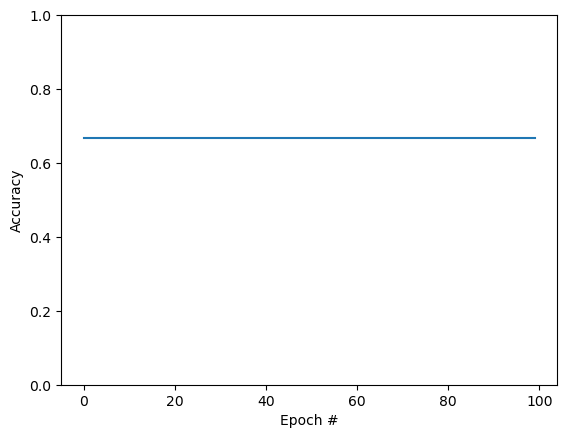

In [77]:
# Custom Perceptron - uses SGD
my_perceptron = Perceptron()
my_perceptron.fit(x_train_scaled, y_train, 100, 0.001)
my_perceptron_acc = accuracy_score(my_perceptron.predict(x_test_scaled.T), y_test)

LDA accuracy: 93.7%


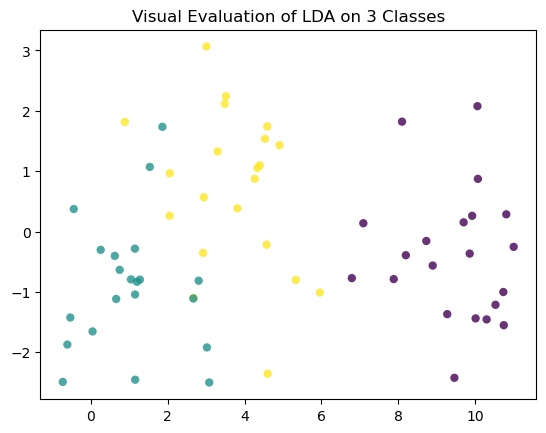

In [79]:
# Custom LDA model - closed form approach
my_lda = LDA(2)
my_lda.fit(x_train, y_train)
lds = my_lda.transform(x_test)

x1, x2 = lds[:, 0], lds[:, 1]

plt.scatter(
    x1, x2, c=y_test, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)
plt.title("Visual Evaluation of LDA on 3 Classes")
my_lda_acc = accuracy_score(my_lda.evaluate(x_test, y_test), y_test)
print(f"LDA accuracy: {100 * round(my_lda_acc, 3)}%")

c)	[15 pts] Implement models (perceptron, LDA, and logistic regression) using Scikit-learn. 

In [83]:
from sklearn.linear_model import Perceptron as SKPerceptron

perceptron_sklearn = SKPerceptron(max_iter=100, random_state=0)
perceptron_sklearn.fit(x_train_scaled, y_train)
perceptron_acc = perceptron_sklearn.score(x_test_scaled, y_test)
print(f"Perceptron accuracy: {100 * round(perceptron_acc, 3)}%")

Perceptron accuracy: 81.0%


In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLinDA

lda = SKLinDA(n_components=2)
lda.fit(x_train_scaled, y_train)
lda_acc = lda.score(x_test_scaled, y_test)
print(f"LDA accuracy: {100 * round(lda_acc, 3)}%")

LDA accuracy: 93.7%


In [88]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=0)
log_reg.fit(x_train_scaled, y_train)
log_reg_acc = log_reg.score(x_test_scaled, y_test)
print(f"Logistic Regression accuracy: {100 * round(log_reg_acc, 3)}%")

Logistic Regression accuracy: 92.10000000000001%


d)	[5 points] Compare the weights obtained and the accuracies of trained models. Did you expect weights to be the same? Explain why or why not? 

In [95]:
print("====== LDA Report ========")
print(f"Custom LDA: \n\t - (accuracy): {100 * round(my_lda_acc, 3)}%")
print(f"\t - (weights): {my_lda.linear_discriminants}")
print(f"Sklearn LDA: \n\t - (accuracy): {100 * round(lda_acc, 3)}%")
print(f"\t - (weights): {lda.coef_}")
print("====== Perceptron Report ========")
print(f"Custom Perceptron: \n\t - (accuracy): {100 * round(my_perceptron_acc, 3)}%")
print(f"\t - (weights): {my_perceptron.w}")
print(f"Sklearn Perceptron: \n\t - (accuracy): {100 * round(perceptron_acc, 3)}%")
print(f"\t - (weights): {perceptron_sklearn.coef_}")
print("====== Logistic Regression Report ========")
print(f"Sklearn LogReg: \n\t - (accuracy): {100 * round(log_reg_acc, 3)}%")
print(f"\t - (weights): {log_reg.coef_}")


====== LDA Report ========
Custom LDA: 
	 - (accuracy): 93.7%
	 - (weights): [[-0.2451322  -0.96948966]
 [-0.97875977  0.20501053]]
Sklearn LDA: 
	 - (accuracy): 93.7%
	 - (weights): [[ -1.14282633 -14.84734219]
 [  2.14007624  10.94902853]
 [ -0.98348092   4.0771973 ]]
====== Perceptron Report ========
Custom Perceptron: 
	 - (accuracy): 66.7%
	 - (weights): [[0.00043479]
 [0.00235844]]
Sklearn Perceptron: 
	 - (accuracy): 81.0%
	 - (weights): [[ 0.50808543 -2.66590291]
 [ 2.49583924  5.49095953]
 [-1.96812744  1.55506819]]
====== Logistic Regression Report ========
Sklearn LogReg: 
	 - (accuracy): 92.10000000000001%
	 - (weights): [[-0.57434921 -4.00098888]
 [ 1.58302376  3.56062319]
 [-1.00867455  0.44036568]]


*LDA*:
As the reports above show, both the custom and `sklearn` implementations of LDA achieved ~93% accuracy. However they have different weights. This could be explained by our approach relying upon eigen decomposition while `sklearn` used SVD by default (albeit I'm not totally aware of the underlying details that affect the shape of the final model weights). Nonetheless, they are still both closed-form solutions so it makes sense that the final accuracy was the same.

*Perceptron*:
As the reports above show, the Sklearn implementation of the perceptron achieved a significantly higher accuracy (~81%) than our own (~66.7%). 
This could be due to simplicity of our class - for example, our implementation leaves out a bias term, l1 and l2 regularization, and there was no `if/elif` block to update the weights in case we mislabelled a sample from thr `2` class. In light of this, it seems reasonable that the Sklearn has more parameters - its implementation means that its decision boundary is parametrized to classify all 3 classes.

*Logistic Regression*:
This model had the 2nd highest accuracy 92% behind LDA. There is no custom implementation to compare to. I did not expect its weights to be the same as the other models, since it relies upon a maximum likelihood function, rather than the LDA and perceptron which depend on a more straightforward linear function.



# Question 4 [20 points]: Linear Regression and regularization

Suppose we decided to reject the linear model for the housing dataset discussed in linear regression lecture (the second model with all features after the preprocessing). Then, we are going to implement a new model that is less complex (lower number of features) and outperform (lower RMSE). 

a)	[10 points] Retrain the dataset. In the new trained dataset, same feature engineering for the continuous features is not allowed while the discrete features may be used as they are. For each process, explain explicitly the reason of work. 

b)	[10 points] Suppose the worst scenario is when the RMSE of new model is higher but within 5% with the same number of features that the original model had. Train five different models (with or without regularizations) and report the results. Select the best model among five models and explain why. 